In [7]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms.transforms import ToTensor

from models.model import My_siamese
from utils.utils import increment_path
from pathlib import Path

from tqdm import tqdm
import wandb

import cv2
import numpy as np
import matplotlib.pyplot as plt

from dataset.reconstruct import prepare_data
from dataset.loader import train_validation_loader
from dataset.loader import testset_loader

# Siamese model & Load

In [5]:

net = My_siamese().cuda()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

load = torch.load("./tutorial/siamese_omniglot_cnn/omniglot_cnn_best.pt")
net.load_state_dict(load["model"])

<All keys matched successfully>

# Data reconstruct & load

In [4]:
data_dir = os.path.join("data")
datasets.Omniglot(data_dir, background=True, download=True, transform=ToTensor())
datasets.Omniglot(data_dir, background=False, download=True, transform=ToTensor())

train_dir, val_dir, test_dir = prepare_data(data_dir, seed=3)
train_loader, val_loader = train_validation_loader(train_dir, val_dir, batch_size=8, augment=False, candi=5, shuffle=True, seed=3, num_workers=8)

# Trainging (once)

In [8]:
net.train()
train_loss = 0
train_acc = 0

for i, (img1, img2, label) in tqdm(enumerate(train_loader), total=len(train_loader)):

    output = net(img1.cuda(), img2.cuda())
    loss = loss_fn(output, label.cuda())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss

    TP_mask = torch.logical_and(output>0, label.cuda()==1)
    TN_mask = torch.logical_and(output<0, label.cuda()==0)
    train_acc += (torch.sum(TP_mask) + torch.sum(TN_mask))/img1.shape[0]

train_loss /= len(train_loader)
train_acc /= len(train_loader)
print("Train_loss", train_loss)
print("Train_accuracy", train_acc)



100%|██████████| 2398/2398 [01:18<00:00, 30.38it/s]

Train_loss tensor(0.0662, device='cuda:0', grad_fn=<DivBackward0>)
Train_accuracy tensor(0.9775, device='cuda:0')


# Validation
* torch_to_cv2 : convert torch to numpy 
* put_result : put the text which contain label and prediction 

In [10]:
def torch_to_cv2(imgs):

    for i, img in enumerate(imgs):

        img = img.cpu()
        img = img.numpy().transpose(1,2,0)
        img = (img -img.min())/(img.max()-img.min())*255

        if i ==0:
            cv_img = img
        else : 
            cv_img = np.concatenate((cv_img, img), axis=1)

    return cv_img

def put_result(img, similar, label, candi):

    split = candi + 1

    w = img.shape[1]//split

    for i in range(split):
        
        if i ==0:
            cv2.putText(img, "Template", (w//4, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 0,2)
        else : 
            s = similar[i-1].item()
            l = int(label[i-1].item())
            cv2.putText(img, f"Result : {s:.2f}", (w//9 + w*i, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 0,2)
            cv2.putText(img, f"Label : {int(l)}", (w//4 + w*i, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 0,2)

    return img   

In [19]:
net.eval()
val_loss = 0
val_acc = 0
val_imgs = []

with torch.no_grad():    
    for i, (img1, img2, label) in tqdm(enumerate(val_loader), total=len(val_loader)):

        output = net(img1.cuda(), img2.cuda())
        loss = loss_fn(output, label.cuda())

        val_loss += loss

        # Accuracy
        TP_mask = torch.logical_and(output>0, label.cuda()==1)
        TN_mask = torch.logical_and(output<0, label.cuda()==0)
        val_acc += (torch.sum(TP_mask) + torch.sum(TN_mask))/img1.shape[0]


        if (i+1) % (len(val_loader)//5) == 0 or i == (len(val_loader) -1):

            pred_img = torch.cat((img1[0].unsqueeze(0),img2))

            pred_img_cv = torch_to_cv2(pred_img)
            result_img = put_result(pred_img_cv, output, label, img1.shape[0])

            val_imgs.append(result_img)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    print("Val_loss", val_loss)
    print("Val_accuracy", val_acc)


100%|██████████| 1256/1256 [00:08<00:00, 145.20it/s]

Val_loss tensor(0.2055, device='cuda:0')
Val_accuracy tensor(0.9347, device='cuda:0')


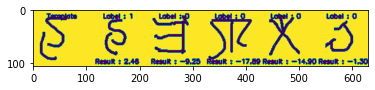

In [25]:
plt.imshow(val_imgs[0])

# Test

In [15]:
test_loader = testset_loader(test_dir, candi=5, seed=3, num_workers=2)

test_loss = 0
test_acc = 0
test_imgs = []

with torch.no_grad():    
    for i, (img1, img2, label) in tqdm(enumerate(test_loader), total=len(test_loader)):

        output = net(img1.cuda(), img2.cuda())
        loss = loss_fn(output, label.cuda())

        test_loss += loss

        # Accuracy
        TP_mask = torch.logical_and(output>0, label.cuda()==1)
        TN_mask = torch.logical_and(output<0, label.cuda()==0)
        test_acc += (torch.sum(TP_mask) + torch.sum(TN_mask))/img1.shape[0]


        if (i+1) % (len(test_loader)//5) == 0 or i == (len(test_loader) -1):

            pred_img = torch.cat((img1[0].unsqueeze(0),img2))

            pred_img_cv = torch_to_cv2(pred_img)
            result_img = put_result(pred_img_cv, output, label, img1.shape[0])

            test_imgs.append(wandb.Image(result_img))

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    print("Test_loss", test_loss)
    print("Test_accuracy", test_acc)


100%|██████████| 1400/1400 [00:09<00:00, 145.13it/s]

Test_loss tensor(0.2172, device='cuda:0')
Test_accuracy tensor(0.9171, device='cuda:0')
